In [1]:
import pandas as pd
from tqdm.auto import tqdm
import os 
import json
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict

In [2]:
# plot the data
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.style.use(['science', 'nature'])
plt.rcParams.update(tex_fonts)

import matplotlib.font_manager

fm = matplotlib.font_manager.json_load("/home/chensun/.cache/matplotlib/fontlist-v330.json")

fm.findfont("serif", rebuild_if_missing=False)

'/home/data/chensun/affi_project/yes/envs/openwpm/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf'

# Calculate average accuracy scores

In [3]:
# calculate different in each iteration
RESULT_DIR = "../../output/results/aff_ads_graph_level_fullGraph"


In [12]:
# seen domain testing with default threshold (0.5)

iteration = 10
accuracy_results = {}
precision_results = {}
recall_results = {}
f1_score_results = {}

for i in range(iteration):
    unseen_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/{i}/with_model_0.3"
    testing_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/{i}"

    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_score_dict = {}

    # Parse accuracy from testing accuracy file
    with open(os.path.join(testing_accuracy_path, "accuracy")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str)
                accuracy_dict["Testing_Accuracy"] = accuracy
            elif "Precision" in line and 'binary' in line:
                precision_str = line.split(":")[1].split(' ')[2].strip().replace("%", "")
                precision = float(precision_str)
                precision_dict["Testing_Precision"] = precision

            elif "Recall" in line and 'binary' in line:
                recall_str = line.split(":")[1].split(' ')[2].strip().replace("%", "")
                recall = float(recall_str)
                recall_dict["Testing_Recall"] = recall

    # Compute F1 score for testing data
    if "Testing_Precision" in precision_dict and "Testing_Recall" in recall_dict:
        P = precision_dict["Testing_Precision"]
        R = recall_dict["Testing_Recall"]
        f1_score_dict["Testing_F1_Score"] = 2 * (P * R) / (P + R) if (P + R) != 0 else 0


    # Parse accuracy from unseen accuracy file
    with open(os.path.join(unseen_accuracy_path, "classification_metrics.txt")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str) * 100.0  # Convert percentage to fraction
                accuracy_dict["Unseen_Accuracy"] = accuracy
            elif "Precision" in line:
                precision = line.split(":")[1].strip().replace("%", "")
                precision = float(precision) * 100.0
                precision_dict["Unseen_Precision"] = precision
            elif "Recall" in line:
                recall = line.split(":")[1].strip().replace("%", "")
                recall = float(recall) * 100.0
                recall_dict["Unseen_Recall"] = recall

    # Compute F1 score for unseen data
    if "Unseen_Precision" in precision_dict and "Unseen_Recall" in recall_dict:
        P = precision_dict["Unseen_Precision"]
        R = recall_dict["Unseen_Recall"]
        f1_score_dict["Unseen_F1_Score"] = 2 * (P * R) / (P + R) if (P + R) != 0 else 0


    accuracy_results[i] = accuracy_dict
    precision_results[i] = precision_dict
    recall_results[i] = recall_dict
    f1_score_results[i] = f1_score_dict


# Now accuracy_results is a dictionary where each key is an iteration number
# and the corresponding value is a dictionary containing testing and unseen accuracy
print(accuracy_results)
print(precision_results)
print(recall_results)
print(f1_score_results)


{0: {'Testing_Accuracy': 97.429, 'Unseen_Accuracy': 91.11111111111111}, 1: {'Testing_Accuracy': 98.25, 'Unseen_Accuracy': 92.87169042769857}, 2: {'Testing_Accuracy': 98.214, 'Unseen_Accuracy': 95.53679131483716}, 3: {'Testing_Accuracy': 95.796, 'Unseen_Accuracy': 88.93034825870647}, 4: {'Testing_Accuracy': 97.276, 'Unseen_Accuracy': 89.88636363636363}, 5: {'Testing_Accuracy': 97.742, 'Unseen_Accuracy': 92.496765847348}, 6: {'Testing_Accuracy': 98.63, 'Unseen_Accuracy': 85.49931600547195}, 7: {'Testing_Accuracy': 97.804, 'Unseen_Accuracy': 93.7354988399072}, 8: {'Testing_Accuracy': 97.61, 'Unseen_Accuracy': 97.66536964980544}, 9: {'Testing_Accuracy': 97.365, 'Unseen_Accuracy': 89.0840652446675}}
{0: {'Testing_Precision': 96.774, 'Unseen_Precision': 87.93363499245852}, 1: {'Testing_Precision': 97.741, 'Unseen_Precision': 89.84848484848484}, 2: {'Testing_Precision': 97.843, 'Unseen_Precision': 93.95017793594306}, 3: {'Testing_Precision': 94.6, 'Unseen_Precision': 85.04672897196261}, 4: {'

In [13]:
# Extract unseen accuracy values from accuracy_results dictionary
iteration = 10
unseen_accuracies = [accuracy_results[i]['Unseen_Accuracy'] for i in range(iteration)]
mean_unseen_accuracy = sum(unseen_accuracies) / len(unseen_accuracies)

unseen_percision = [precision_results[i]['Unseen_Precision'] for i in range(iteration)]
mean_unseen_percision = sum(unseen_percision) / len(unseen_percision)

unseen_recall = [recall_results[i]['Unseen_Recall'] for i in range(iteration)]
mean_unseen_recall = sum(unseen_recall) / len(unseen_recall)

print("Mean Unseen Accuracy:", mean_unseen_accuracy)
print("Mean Unseen Precision:", mean_unseen_percision)
print("Mean Unseen Recall:", mean_unseen_recall)


Mean Unseen Accuracy: 91.68173203359171
Mean Unseen Precision: 88.90795022699473
Mean Unseen Recall: 98.39012569868238


In [6]:
# Extract testing accuracy values from accuracy_results dictionary
iteration = 5
testing_Accuracy = [accuracy_results[i]['Testing_Accuracy'] for i in range(iteration)]
mean_testing_Accuracy = sum(testing_Accuracy) / len(testing_Accuracy)

testing_percision = [precision_results[i]['Testing_Precision'] for i in range(iteration)]
mean_testing_percision = sum(testing_percision) / len(testing_percision)

testing_recall = [recall_results[i]['Testing_Recall'] for i in range(iteration)]
mean_testing_recall = sum(testing_recall) / len(testing_recall)

print("Mean Testing Accuracy:", mean_testing_Accuracy)
print("Mean Testing Precision:", mean_testing_percision)
print("Mean Testing Recall:", mean_testing_recall)

Mean Testing Accuracy: 97.393
Mean Testing Precision: 96.68979999999999
Mean Testing Recall: 99.396


In [20]:
# seen domain testing with different threshold

iteration = 5
accuracy_results = {}
precision_results = {}
recall_results = {}
f1_score_results = {}

for i in range(iteration):
    unseen_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/04_22_yt_threshold=0.25_undersampling_5fold_CV_importantF/phase1/{i}/with_model_0.05"
    testing_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/04_22_yt_threshold=0.25_undersampling_5fold_CV_importantF/phase1/{i}/seen_data_with_model_0.4"

    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_score_dict = {}

    # Parse accuracy from testing accuracy file
    with open(os.path.join(testing_accuracy_path, "classification_metrics.txt")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str) * 100.0  # Convert percentage to fraction
                accuracy_dict["Testing_Accuracy"] = accuracy
            elif "Precision" in line:
                precision = line.split(":")[1].strip().replace("%", "")
                precision = float(precision) * 100.0
                precision_dict["Testing_Precision"] = precision
            elif "Recall" in line:
                recall = line.split(":")[1].strip().replace("%", "")
                recall = float(recall) * 100.0
                recall_dict["Testing_Recall"] = recall

    # Compute F1 score for testing data
    if "Testing_Precision" in precision_dict and "Testing_Recall" in recall_dict:
        P = precision_dict["Testing_Precision"]
        R = recall_dict["Testing_Recall"]
        f1_score_dict["Testing_F1_Score"] = 2 * (P * R) / (P + R) if (P + R) != 0 else 0


    # Parse accuracy from unseen accuracy file
    with open(os.path.join(unseen_accuracy_path, "classification_metrics.txt")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str) * 100.0  # Convert percentage to fraction
                accuracy_dict["Unseen_Accuracy"] = accuracy
            elif "Precision" in line:
                precision = line.split(":")[1].strip().replace("%", "")
                precision = float(precision) * 100.0
                precision_dict["Unseen_Precision"] = precision
            elif "Recall" in line:
                recall = line.split(":")[1].strip().replace("%", "")
                recall = float(recall) * 100.0
                recall_dict["Unseen_Recall"] = recall

    # Compute F1 score for unseen data
    if "Unseen_Precision" in precision_dict and "Unseen_Recall" in recall_dict:
        P = precision_dict["Unseen_Precision"]
        R = recall_dict["Unseen_Recall"]
        f1_score_dict["Unseen_F1_Score"] = 2 * (P * R) / (P + R) if (P + R) != 0 else 0


    accuracy_results[i] = accuracy_dict
    precision_results[i] = precision_dict
    recall_results[i] = recall_dict
    f1_score_results[i] = f1_score_dict


# Now accuracy_results is a dictionary where each key is an iteration number
# and the corresponding value is a dictionary containing testing and unseen accuracy
print(accuracy_results)
print(precision_results)
print(recall_results)
print(f1_score_results)


# Extract unseen accuracy values from accuracy_results dictionary
iteration = 5
unseen_accuracies = [accuracy_results[i]['Unseen_Accuracy'] for i in range(iteration)]
mean_unseen_accuracy = sum(unseen_accuracies) / len(unseen_accuracies)

unseen_percision = [precision_results[i]['Unseen_Precision'] for i in range(iteration)]
mean_unseen_percision = sum(unseen_percision) / len(unseen_percision)

unseen_recall = [recall_results[i]['Unseen_Recall'] for i in range(iteration)]
mean_unseen_recall = sum(unseen_recall) / len(unseen_recall)

print("Mean Unseen Accuracy:", mean_unseen_accuracy)
print("Mean Unseen Precision:", mean_unseen_percision)
print("Mean Unseen Recall:", mean_unseen_recall)

# Extract testing accuracy values from accuracy_results dictionary
iteration = 5
testing_Accuracy = [accuracy_results[i]['Testing_Accuracy'] for i in range(iteration)]
mean_testing_Accuracy = sum(testing_Accuracy) / len(testing_Accuracy)

testing_percision = [precision_results[i]['Testing_Precision'] for i in range(iteration)]
mean_testing_percision = sum(testing_percision) / len(testing_percision)

testing_recall = [recall_results[i]['Testing_Recall'] for i in range(iteration)]
mean_testing_recall = sum(testing_recall) / len(testing_recall)

print("Mean Testing Accuracy:", mean_testing_Accuracy)
print("Mean Testing Precision:", mean_testing_percision)
print("Mean Testing Recall:", mean_testing_recall)

{0: {'Testing_Accuracy': 99.50518014535334, 'Unseen_Accuracy': 94.63276836158192}, 1: {'Testing_Accuracy': 99.58204334365325, 'Unseen_Accuracy': 91.5875169606513}, 2: {'Testing_Accuracy': 99.42962848774472, 'Unseen_Accuracy': 91.3907284768212}, 3: {'Testing_Accuracy': 99.55212355212355, 'Unseen_Accuracy': 94.29429429429429}, 4: {'Testing_Accuracy': 99.51915619668063, 'Unseen_Accuracy': 95.59748427672956}}
{0: {'Testing_Precision': 95.41284403669725, 'Unseen_Precision': 94.18181818181817}, 1: {'Testing_Precision': 94.73684210526315, 'Unseen_Precision': 92.62536873156341}, 2: {'Testing_Precision': 92.67241379310344, 'Unseen_Precision': 91.8918918918919}, 3: {'Testing_Precision': 95.51569506726457, 'Unseen_Precision': 91.85185185185185}, 4: {'Testing_Precision': 95.17543859649122, 'Unseen_Precision': 88.4}}
{0: {'Testing_Recall': 90.43478260869566, 'Unseen_Recall': 92.17081850533808}, 1: {'Testing_Recall': 92.5233644859813, 'Unseen_Recall': 89.45868945868945}, 2: {'Testing_Recall': 91.489

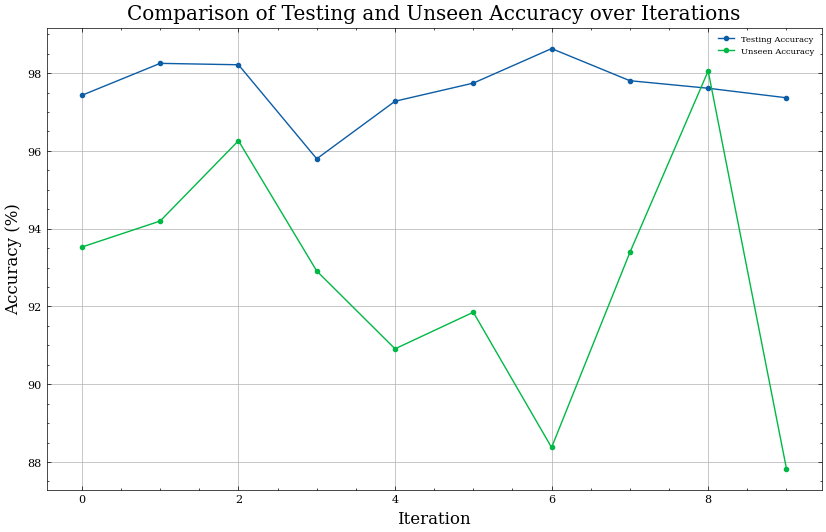

In [7]:
# comparison between Testing Accuracy and Unseen Accuracy for each iteration
iterations = list(accuracy_results.keys())
testing_accuracy = [accuracy_results[i]['Testing_Accuracy'] for i in iterations]
unseen_accuracy = [accuracy_results[i]['Unseen_Accuracy'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_accuracy, label='Testing Accuracy', marker='o')
plt.plot(iterations, unseen_accuracy, label='Unseen Accuracy', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Testing and Unseen Accuracy over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

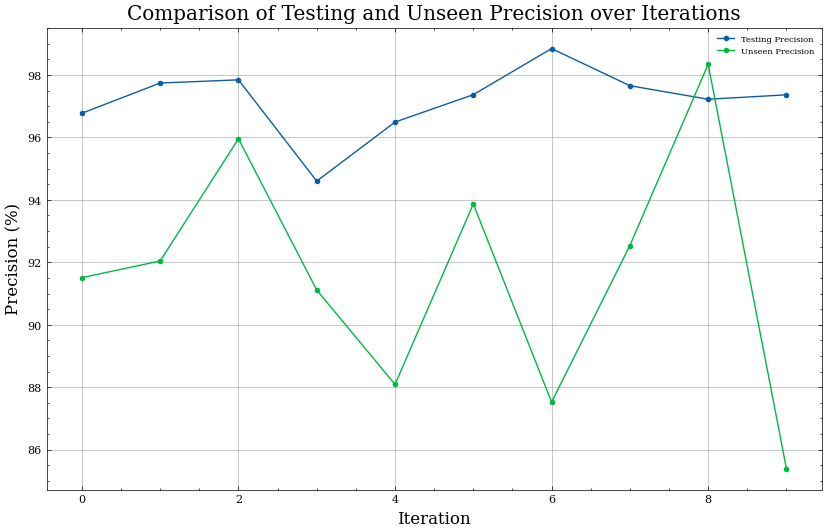

In [8]:
# comparison between Testing Precision and Unseen Precision for each iteration
iterations = list(precision_results.keys())
testing_percision = [precision_results[i]['Testing_Precision'] for i in iterations]
unseen_percision = [precision_results[i]['Unseen_Precision'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_percision, label='Testing Precision', marker='o')
plt.plot(iterations, unseen_percision, label='Unseen Precision', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Precision (%)')
plt.title('Comparison of Testing and Unseen Precision over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

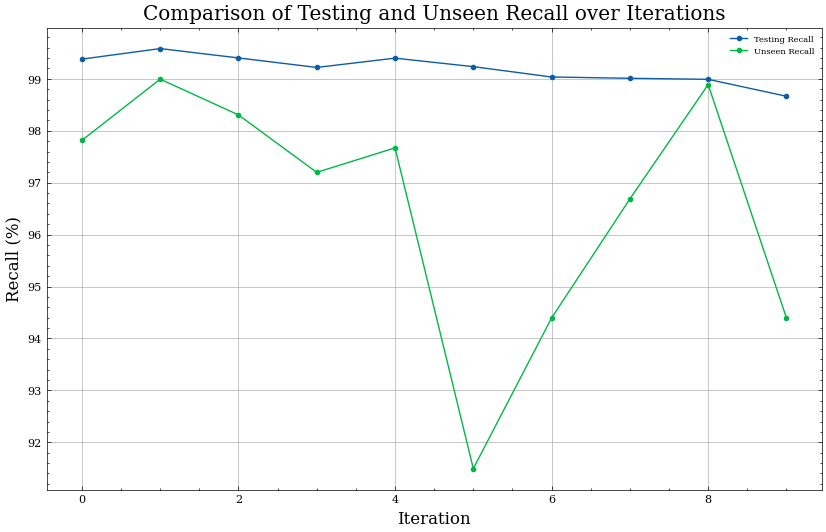

In [9]:
# comparison between Testing Precision and Unseen Precision for each iteration
iterations = list(recall_results.keys())
testing_recall = [recall_results[i]['Testing_Recall'] for i in iterations]
unseen_recall = [recall_results[i]['Unseen_Recall'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_recall, label='Testing Recall', marker='o')
plt.plot(iterations, unseen_recall, label='Unseen Recall', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Recall (%)')
plt.title('Comparison of Testing and Unseen Recall over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

Extract all the FP and FN links, and save back

In [10]:
# Loop over each iteration
iteration = 10
for i in range(iteration):
    # Load the feature importance file for this iteration
    unseen_path = f"/home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/{i}/with_model_0.5"
    unseen_csv = os.path.join(unseen_path, 'labelled_results.csv')
    df = pd.read_csv(unseen_csv)

    #seen_path = f"/home/data/chensun/affi_project/purl/output/results/04_23_yt_threshold=0.25_undersampling_5fold_CV_importantF/phase1/{i}/seen_data_with_model_0.4"
    #seen_csv = os.path.join(seen_path, 'labelled_results.csv')
    #df = pd.read_csv(seen_csv)
    
    # False Negative (FN): True label is 'affiliate' but predicted as 'others'
    df_fn = df[(df['label'] == 'affiliate') & (df['clabel'] == 'others')]
    
    # False Positive (FP): True label is 'others' but predicted as 'affiliate'
    df_fp = df[(df['label'] == 'others') & (df['clabel'] == 'affiliate')]
    
    # Define file paths
    fn_file_path = os.path.join(unseen_path, 'false_negatives.csv')
    fp_file_path = os.path.join(unseen_path, 'false_positives.csv')
    
    # Save the dataframes to CSV
    df_fn.to_csv(fn_file_path, index=False)
    df_fp.to_csv(fp_file_path, index=False)
    
    print(f"False negatives saved to {fn_file_path}")
    print(f"False positives saved to {fp_file_path}")


False negatives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/0/with_model_0.5/false_negatives.csv
False positives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/0/with_model_0.5/false_positives.csv
False negatives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/1/with_model_0.5/false_negatives.csv
False positives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/1/with_model_0.5/false_positives.csv
False negatives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1/2/with_model_0.5/false_negatives.csv
False positives saved to /home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_

Get the important features from each round of iteration

In [14]:
feature_importance_directory = "/home/data/chensun/affi_project/purl/output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/phase1"

# Initialize a dictionary to store cumulative importance for each feature
cumulative_importance = defaultdict(float)

# Loop over each iteration
iteration = 10
for i in range(iteration):
    # Load the feature importance file for this iteration
    importance_file_path = os.path.join(feature_importance_directory, str(i), "featimp")
    
    # Read the file and extract the importance values
    with open(importance_file_path) as f:
        # Skip the header line
        next(f)
        # Read the remaining lines
        for line in f:
            # Split the line into feature and importance value
            feature, importance = line.strip().split()
            # Convert importance to float
            importance = float(importance)
            # Add the importance to the cumulative importance for this feature
            cumulative_importance[feature] += importance

# Sort the features based on cumulative importance
sorted_features = sorted(cumulative_importance.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 important features
top_10_features = sorted_features[:30]

# Print the top 10 important features
print("Top 30 Important Features:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")

Top 30 Important Features:
total_num_query_params: 2.29447
landing_url_num_query_params: 0.904126
average_num_query_params: 0.7849820000000001
num_nodes: 0.6865110000000001
landing_url_shannon_entropy: 0.593424
std_dev_degree_centrality: 0.522139
num_edges: 0.4947909999999999
total_num_path_depth: 0.44001599999999996
num_of_redirect: 0.347961
std_dev_closeness_centrality_outward: 0.318343
average_num_path_depth: 0.248473
average_degree_centrality: 0.23515600000000003
average_shannon_entropy: 0.228369
density: 0.193686
median_closeness_centrality: 0.16836399999999999
max_closeness_centrality_outward: 0.149036
average_closeness_centrality: 0.14717999999999998
median_degree_centrality: 0.11796100000000001
max_degree_centrality: 0.11528100000000001
avg_clustering_coefficient: 0.089362
max_avg_path_length: 0.079347
landing_url_path_depth: 0.071334
nodes_div_by_edges: 0.06916399999999999
std_dev_closeness_centrality: 0.06898699999999999
transitivity: 0.068686
average_closeness_centrality_out

Merge the labels and records with the classified result

In [20]:
def append_csv_data(folder_path, file_name, df_accumulator):
    """Appends data from CSV files """
    for crawl_id in os.listdir(folder_path):
        each_crawl = os.path.join(folder_path, crawl_id)
        file_path = os.path.join(each_crawl, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, on_bad_lines='skip')
            df['visit_id'] = df['visit_id'].astype(str)
            if file_name == 'url_features.csv':
                df = df.drop_duplicates(subset=["visit_id"])
            
            df_accumulator = df_accumulator.append(df)
    return df_accumulator


others_folder = "../../output/rule_based_others_yt"
affiliate_folder = "../../output/rule_based_aff_yt"

df_affiliate_labels, df_affiliate_redirect_chains = pd.DataFrame(), pd.DataFrame()
df_others_labels, df_others_redirect_chains = pd.DataFrame(), pd.DataFrame()

df_affiliate_labels = append_csv_data(affiliate_folder, "rule_based_label.csv", df_affiliate_labels)
df_affiliate_redirect_chains = append_csv_data(affiliate_folder, "redirect_chains.csv", df_affiliate_redirect_chains)

df_others_labels = append_csv_data(others_folder, "rule_based_label.csv", df_others_labels)
df_others_redirect_chains = append_csv_data(others_folder, "redirect_chains.csv", df_others_redirect_chains)

df_labels = pd.DataFrame()
df_labels = pd.concat([df_others_labels,df_affiliate_labels])

df_redirect_chains = pd.DataFrame()
df_redirect_chains = pd.concat([df_others_redirect_chains,df_affiliate_redirect_chains])

print(len(df_redirect_chains))
print(df_redirect_chains.columns)
print(len(df_labels))
print(df_labels.columns)



751652
Index(['visit_id', 'url', 'redirect_chain', 'parent_page_url', 'url_domain',
       'redirect_domain_by_component', 'redirect_domain_total'],
      dtype='object')
751494
Index(['visit_id', 'url', 'redirect_domain_total', 'match', 'rule_description',
       'final_rules_based_label', 'last_domain'],
      dtype='object')


In [30]:
features_types = ["phase1"]
num_trials = 10

for iteration in range(num_trials):
    for feature_type in features_types:
        model_path = f"../../output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/{feature_type}/{iteration}/best_model.sav"
        result_dir = f"../../output/results/05_08_yt_threshold=0.5_undersampling_5fold_CV_reducedF/{feature_type}/{iteration}/with_model_0.5"
        
        print(f"Classifying unseen data with {feature_type} features")
        
        labelled_results_data_path = f"{result_dir}/labelled_results.csv"
        df_labelled = pd.read_csv(labelled_results_data_path)
        
        # Merging operations without suffixes as it seems they were not added as expected
        merged_df = df_labelled.merge(df_labels, on="visit_id", how="left")
        merged_df = merged_df.merge(df_redirect_chains, on="visit_id", how="left")

        # Check column names after merge
        print("Columns after merge:", merged_df.columns.tolist())
        
        
        
        # Keeping specific columns, adjusted to actually present names
        final_columns = [
            'visit_id', 
            'url_x',
            'final_rules_based_label',
            'clabel',
            'clabel_prob',
            'redirect_domain_total_y',  # Corrected to actual column name (without suffix)
            'rule_description',  # Corrected to actual column name (without suffix)
            'parent_page_url' # Corrected to actual column name
        ]
        
        
        final_df = merged_df[final_columns]
        
        final_df = final_df.rename(columns={
            'url_x': 'url',
            'redirect_domain_total_y': 'redirect_domain_total',
            'final_rules_based_label': 'label'
        })
        
        unique_df = final_df.drop_duplicates()
        
        
        # Save the final dataframe
        unique_df.to_csv(f"{result_dir}/labelled_results_info.csv", index=False)
        print(f"Results saved in {result_dir}/labelled_results_info.csv")

Classifying unseen data with phase1 features
Columns after merge: ['visit_id', 'top_level_url', 'num_nodes', 'num_edges', 'max_in_degree', 'max_out_degree', 'nodes_div_by_edges', 'edges_div_by_nodes', 'density', 'largest_cc', 'transitivity', 'average_path_length_for_largest_cc', 'average_degree', 'average_out_degree', 'median_in_degree', 'avg_clustering_coefficient', 'smallest_cc', 'max_avg_path_length', 'average_degree_centrality', 'median_degree_centrality', 'max_degree_centrality', 'std_dev_degree_centrality', 'average_closeness_centrality', 'median_closeness_centrality', 'max_closeness_centrality', 'std_dev_closeness_centrality', 'average_closeness_centrality_outward', 'max_closeness_centrality_outward', 'std_dev_closeness_centrality_outward', 'landing_url_num_query_params', 'landing_url_path_depth', 'landing_url_shannon_entropy', 'num_of_redirect', 'average_shannon_entropy', 'average_num_query_params', 'average_num_path_depth', 'total_num_query_params', 'total_num_path_depth', 'la

In [ ]:
df_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/55/result.csv')

Analyze misclassification by each domain

In [14]:
"""
count occurrences of "affiliate" and "other" in two columns (label and clabel) 
for each unique landing_page_domain
"""

# Function to calculate confusion matrix components
def confusion_matrix_components(group):
    tp = sum((group['label'] == 'affiliate') & (group['clabel'] == 'affiliate'))
    tn = sum((group['label'] == 'others') & (group['clabel'] == 'others'))
    fp = sum((group['label'] == 'others') & (group['clabel'] == 'affiliate'))
    fn = sum((group['label'] == 'affiliate') & (group['clabel'] == 'others'))
    return pd.Series({'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn})

# Loop over each iteration
iteration = 100
for i in range(iteration):

    if i != 0:
        continue
    # Load the feature importance file for this iteration

    folder = f"/home/data/chensun/affi_project/purl/output/results/04_11_default_RF_yt_uniform_Kfold_CV_AFF_OTHERS/phase1/{i}/with_model/"
    labelled_results = os.path.join(folder, "labelled_results.csv")
    result_dir = os.path.join(folder,"domain_labelled_results.csv")
    df = pd.read_csv(labelled_results)
    
    

    # Convert 'label' and 'clabel' to integers for easier summation
    df['aff_in_label'] = (df['label'] == 'affiliate').astype(int)
    df['non_aff_in_label'] = (df['label'] == 'others').astype(int)
    df['aff_in_clabel'] = (df['clabel'] == 'affiliate').astype(int)
    df['non_aff_in_clabel'] = (df['clabel'] == 'others').astype(int)

    # Group by 'landing_page_domain' and sum
    result = df.groupby('landing_page_domain').agg({
        'aff_in_label': 'sum',
        'non_aff_in_label': 'sum',
        'aff_in_clabel': 'sum',
        'non_aff_in_clabel': 'sum'
    }).reset_index()

    # Rename columns if necessary and display the result
    result.columns = ['landing_page_domain', '#aff_in_label', '#non_aff_in_label', '#aff_in_clabel', '#non_aff_in_clabel']
    #print(result)


    # Group by 'landing_page_domain' and apply the function
    metrics = df.groupby('landing_page_domain').apply(confusion_matrix_components)
    
    # Calculate performance metrics
    metrics['Precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
    metrics['Recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
    metrics['Accuracy'] = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
    metrics['F1 Score'] = 2 * (metrics['Precision'] * metrics['Recall']) / (metrics['Precision'] + metrics['Recall'])

    # Handle NaN values in case of division by zero
    metrics.fillna(0, inplace=True)

    metrics_sorted = metrics.sort_values(by=['FP', 'FN'], ascending=[False, False])

    print(metrics)
    metrics_sorted.to_csv(result_dir, index=True)    

                     TP  TN  FP  FN  Precision  Recall  Accuracy  F1 Score
landing_page_domain                                                       
ae.com                1   0   0   0        1.0     1.0  1.000000       1.0
ariat.com             0   0   0   3        0.0     0.0  0.000000       0.0
artgrid.io            0  29   0   1        0.0     0.0  0.966667       0.0
avalonking.com        0   3   0   1        0.0     0.0  0.750000       0.0
axe.com               0   1   0   0        0.0     0.0  1.000000       0.0
...                  ..  ..  ..  ..        ...     ...       ...       ...
warbyparker.com       8   0   0   0        1.0     1.0  1.000000       1.0
westelm.com          10   0   0   0        1.0     1.0  1.000000       1.0
younow.com            0  12   0   0        0.0     0.0  1.000000       0.0
zaful.com             0   0   0   2        0.0     0.0  0.000000       0.0
zhcstore.com          0  28   0   0        0.0     0.0  1.000000       0.0

[72 rows x 8 columns]


In [21]:
# check domain
# If 90% url of the domain is label correct, which mean true label match predicted label, then this domain is "correct label"

def classify_and_evaluate_by_domain(df, threshold=0.90):
    # Check if each prediction is correct
    df['correct'] = (df['label'] == df['clabel']).astype(int)

    # Calculate the percentage of correct predictions per domain
    domain_accuracy = df.groupby('landing_page_domain')['correct'].mean()

    # Check if the domain accuracy meets the threshold
    domain_correctly_labeled = domain_accuracy >= threshold

    # Calculate overall percentage of domains correctly labeled
    overall_percentage = domain_correctly_labeled.mean()

    # Print results
    print(f"Percentage of domains correctly labeled (>= {threshold*100}% accuracy): {overall_percentage:.2f}")
    return domain_accuracy, domain_correctly_labeled



folder = f"/home/data/chensun/affi_project/purl/output/results/04_11_default_RF_yt_uniform_Kfold_CV_AFF_OTHERS/phase1/0/with_model_0.2/"
labelled_results = os.path.join(folder, "labelled_results.csv")

df = pd.read_csv(labelled_results)
domain_accuracy, domains_correctly_labeled = classify_and_evaluate_by_domain(df)
print("domain_accuracy: ", domain_accuracy)
print("\n", domains_correctly_labeled)

Percentage of domains correctly labeled (>= 90.0% accuracy): 0.85
domain_accuracy:  landing_page_domain
ae.com             1.000000
ariat.com          1.000000
artgrid.io         0.966667
avalonking.com     1.000000
axe.com            1.000000
                     ...   
warbyparker.com    1.000000
westelm.com        1.000000
younow.com         1.000000
zaful.com          0.000000
zhcstore.com       1.000000
Name: correct, Length: 72, dtype: float64

 landing_page_domain
ae.com              True
ariat.com           True
artgrid.io          True
avalonking.com      True
axe.com             True
                   ...  
warbyparker.com     True
westelm.com         True
younow.com          True
zaful.com          False
zhcstore.com        True
Name: correct, Length: 72, dtype: bool


In [ ]:

def evaluate_affiliate_accuracy_by_domain(df, threshold=0.90):
    # Filter rows where the true label is 'affiliate'
    affiliate_df = df[df['label'] == 'affiliate']

    # Check if each affiliate prediction is correct
    affiliate_df['correct'] = (affiliate_df['label'] == affiliate_df['clabel']).astype(int)

    # Calculate the percentage of correct predictions per domain for affiliates
    domain_affiliate_accuracy = affiliate_df.groupby('landing_page_domain')['correct'].mean()

    # Check if the domain accuracy for affiliates meets the threshold
    domain_correctly_labeled = domain_affiliate_accuracy >= threshold

    # Calculate overall percentage of domains correctly labeled
    overall_percentage = domain_correctly_labeled.mean()

    # Print results
    print(f"Percentage of domains correctly labeling >= {threshold*100}% of affiliate URLs: {overall_percentage:.2f}")
    return domain_affiliate_accuracy, domain_correctly_labeled

folder = f"/home/data/chensun/affi_project/purl/output/results/04_11_default_RF_yt_uniform_Kfold_CV_AFF_OTHERS/phase1/0/with_model_0.2/"
labelled_results = os.path.join(folder, "labelled_results.csv")

df = pd.read_csv(labelled_results)
domain_accuracy, domains_correctly_labeled = evaluate_affiliate_accuracy_by_domain(df)
print("domain_accuracy: ", domain_accuracy)
print("\n", domains_correctly_labeled)

========

In [18]:
unseen_iteration = "/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/57/with_model/labelled_results.csv"
df = pd.read_csv(unseen_iteration)

In [22]:
# Filter the DataFrame where url_domain is equal to x
filtered_df = df[df['url_domain'] == "revcontent.com"]

# Count the number of matches between ctrue and true columns
num_matches = (filtered_df['clabel'] == filtered_df['label']).sum()
print(num_matches)

5


In [17]:
RESULT_DIR = "../../output/results/aff_ads_graph_level_fullGraph"

with open(os.path.join(RESULT_DIR, "accuracy")) as f:
    lines = f.readlines()
    print(lines)

    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    count = 0
    for line in lines:
        accuracy = 0
        precision = 0
        recall = 0
        if "Accuracy" in line:
            accuracy = line.split(":")[1].strip()
        elif "Precision" in line and 'binary' in line:
            precision = line.split(":")[1].split(' ')[2].strip()
        elif "Recall" in line and 'binary' in line:
            recall = line.split(":")[1].split(' ')[2].strip()
        
        


FileNotFoundError: [Errno 2] No such file or directory: '../../output/results/aff_ads_graph_level_fullGraph/accuracy'

In [41]:
df_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/55/result.csv')
#df_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_14_LeaveOneGroupOut/phase1/result.csv')

In [42]:
# Separate data into two groups based on the label
ads_data = df_labeled[df_labeled['label'] == 'ads']['max_out_degree']
affiliate_data = df_labeled[df_labeled['label'] == 'affiliate']['max_out_degree']

# Perform T-test
t_statistic, p_value = ttest_ind(ads_data, affiliate_data)

# Interpret results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

The difference in means is statistically significant.


In [49]:
df = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/55/with_model/labelled_results.csv')
filtered_df = df[df['url_domain'] == 'amazon.com']
same_data = filtered_df[filtered_df['label'] == filtered_df['clabel']]
print(len(same_data))
different_data = filtered_df[filtered_df['label'] != filtered_df['clabel']]
print(len(different_data))

24
3


In [54]:
same_data[same_data.label == 'affiliate'].average_closeness_centrality_outward .describe()

count    24.000000
mean      0.067688
std       0.009591
min       0.045455
25%       0.062500
50%       0.066667
75%       0.071429
max       0.100000
Name: average_closeness_centrality_outward, dtype: float64

In [55]:
different_data[different_data.label == 'affiliate'].average_closeness_centrality_outward .describe()

count    3.000000
mean     0.076923
std      0.000000
min      0.076923
25%      0.076923
50%      0.076923
75%      0.076923
max      0.076923
Name: average_closeness_centrality_outward, dtype: float64

In [26]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.max_out_degree < 1.25][df_labeled.label == 'affiliate'].max_out_degree, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.max_out_degree < 1.25][df_labeled.label == 'ads'].max_out_degree, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("num_all_gets_in_product_node")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/nodes_div_by_edges.pdf", dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'num_all_gets_in_product_node'

In [32]:
df_labeled[df_labeled.label == 'ads'].max_out_degree.describe()

count    191.000000
mean      22.146597
std       20.338697
min        4.000000
25%       12.000000
50%       17.000000
75%       27.000000
max      188.000000
Name: max_out_degree, dtype: float64

In [23]:
# Analysis unseen data
df_unseen_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_LeaveOneGroupOut/phase1/57/with_model/labelled_results.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/chensun/affi_project/purl/output/results/02_21_LeaveOneGroupOut/phase1/57/with_model/labelled_results.csv'

In [68]:
domain_url_counts = df_unseen_labeled.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'mfadsrvr.com': 25, '6q33.net': 12, '14trackdomain.com': 10, 'kqzyfj.com': 3, 'gonzagabulletin.com': 2, 'jetpackdigital.com': 2, 'kgfjrb711.com': 2, 'dyson.com': 1, 'eventbrite.es': 1, 'peachandlily.com': 1}


In [97]:
same_data = df_unseen_labeled[df_unseen_labeled['label'] == df_unseen_labeled['clabel']]
different_data = df_unseen_labeled[df_unseen_labeled['label'] != df_unseen_labeled['clabel']]

# List of dictionaries for same label
same_data_list = []
for index, row in same_data.iterrows():
    data_dict = {
        "visit_id": row["visit_id"],
        "smallest_cc": row["smallest_cc"],
        "max_avg_path_length": row["max_avg_path_length"],
        "max_closeness_centrality_outward": row["max_closeness_centrality_outward"],
        "largest_cc": row["largest_cc"],
        "max_degree_centrality": row["max_degree_centrality"]

    }
    same_data_list.append(data_dict)

# List of dictionaries for different label
different_data_list = []
for index, row in different_data.iterrows():
    data_dict = {
        "visit_id": row["visit_id"],
        "smallest_cc": row["smallest_cc"],
        "max_avg_path_length": row["max_avg_path_length"],
        "max_closeness_centrality_outward": row["max_closeness_centrality_outward"],
        "largest_cc": row["largest_cc"],
        "max_degree_centrality": row["max_degree_centrality"]
    }
    different_data_list.append(data_dict)

for i in same_data_list:
    print(i)
for i in different_data_list:
    print(different_data_list)

{'visit_id': '4310387995808155_4', 'smallest_cc': 26, 'max_avg_path_length': 2.3692307692307693, 'max_closeness_centrality_outward': 0.6, 'largest_cc': 26, 'max_degree_centrality': 0.64}
{'visit_id': '4310387995808155_5', 'smallest_cc': 2, 'max_avg_path_length': 3.841407867494824, 'max_closeness_centrality_outward': 0.323943661971831, 'largest_cc': 70, 'max_degree_centrality': 0.3380281690140845}
{'visit_id': '4310387995808155_6', 'smallest_cc': 34, 'max_avg_path_length': 2.449197860962567, 'max_closeness_centrality_outward': 0.6363636363636364, 'largest_cc': 34, 'max_degree_centrality': 0.6666666666666667}
{'visit_id': '4310387995808155_8', 'smallest_cc': 20, 'max_avg_path_length': 2.321052631578948, 'max_closeness_centrality_outward': 0.6551724137931034, 'largest_cc': 20, 'max_degree_centrality': 0.5789473684210527}
{'visit_id': '4310387995808155_9', 'smallest_cc': 36, 'max_avg_path_length': 2.552380952380952, 'max_closeness_centrality_outward': 0.6, 'largest_cc': 36, 'max_degree_cen

In [98]:
# unique url domain in correct label
domain_url_counts = same_data.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'mfadsrvr.com': 16, '14trackdomain.com': 9, 'gonzagabulletin.com': 2, 'kgfjrb711.com': 2, 'kqzyfj.com': 2, '6q33.net': 1, 'dyson.com': 1, 'eventbrite.es': 1, 'peachandlily.com': 1}


In [79]:
# unique url domain in incorrect label
domain_url_counts = different_data.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'6q33.net': 11, 'mfadsrvr.com': 9, 'jetpackdigital.com': 2, '14trackdomain.com': 1, 'kqzyfj.com': 1}


In [99]:
# analyze incorrect label domain
different_data_filtered = different_data[different_data['url_domain'] == '6q33.net']

In [100]:
different_data_filtered[different_data_filtered.label == 'affiliate'].max_degree_centrality.describe()

count    11.000000
mean      0.732955
std       0.080507
min       0.592593
25%       0.689959
50%       0.767442
75%       0.780193
max       0.809524
Name: max_degree_centrality, dtype: float64

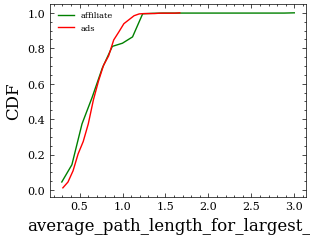

In [33]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_degree_centrality, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'ads'].max_degree_centrality, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("average_path_length_for_largest_cc")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/01_24/std_dev_closeness_centrality.pdf", dpi=300, bbox_inches='tight')

In [35]:
df_labeled[df_labeled.label == 'ads'].max_degree_centrality.describe()

count    490.000000
mean       0.679662
std        0.211800
min        0.245714
25%        0.517130
50%        0.652618
75%        0.826714
max        1.666667
Name: max_degree_centrality, dtype: float64

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/avg_clustering_coefficient.pdf'

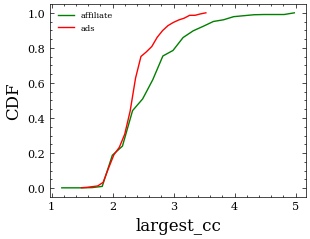

In [29]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_avg_path_length, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'ads'].max_avg_path_length, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("largest_cc")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/avg_clustering_coefficient.pdf", dpi=300, bbox_inches='tight')

In [31]:
df_labeled[df_labeled.label == 'ads'].max_avg_path_length.describe()

count    494.000000
mean       2.345440
std        0.347962
min        1.400000
25%        2.140351
50%        2.328609
75%        2.458257
max        3.529370
Name: max_avg_path_length, dtype: float64

/tmp/ipykernel_100071/767929108.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_negative = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'affiliate'].counts_decoration, 24)
/tmp/ipykernel_100071/767929108.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_positive = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'ads'].counts_decoration, 24)


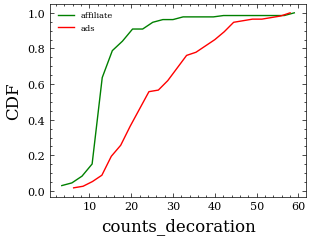

In [39]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'affiliate'].counts_decoration, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'ads'].counts_decoration, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("counts_decoration")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/counts_decoration.pdf", dpi=300, bbox_inches='tight')

In [42]:
df_labeled[df_labeled.label == 'ads'].ascendant_has_ad_keyword.describe()

count    114.000000
mean       0.898288
std        0.149537
min        0.230769
25%        0.810847
50%        1.000000
75%        1.000000
max        1.000000
Name: ascendant_has_ad_keyword, dtype: float64

/tmp/ipykernel_100071/1007004516.py:3: RuntimeWarning: divide by zero encountered in divide
  pdf_negative = count / sum(count)
/tmp/ipykernel_100071/1007004516.py:3: RuntimeWarning: invalid value encountered in divide
  pdf_negative = count / sum(count)


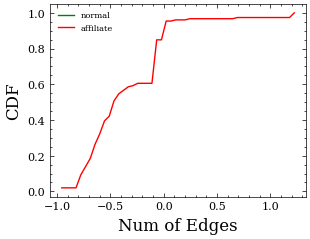

In [43]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'normal'].max_depth_decoration, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="normal", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_depth_decoration, 50)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="affiliate", color='red')
plt.legend()
plt.xlabel("Num of Edges")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_normal_mean_phaseA/max_depth_decoration.pdf", dpi=300, bbox_inches='tight')

In [44]:
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'Negative'].shannon_entropy, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)

/tmp/ipykernel_100071/346222907.py:2: RuntimeWarning: divide by zero encountered in divide
  pdf_negative = count / sum(count)
/tmp/ipykernel_100071/346222907.py:2: RuntimeWarning: invalid value encountered in divide
  pdf_negative = count / sum(count)


In [45]:
cdf_negative[24]

nan

In [46]:
cdf_positive[24]

0.9605263157894738

In [47]:
bins_negative[24]

0.48

/tmp/ipykernel_100071/4016665578.py:3: RuntimeWarning: divide by zero encountered in divide
  pdf = count / sum(count)
/tmp/ipykernel_100071/4016665578.py:3: RuntimeWarning: invalid value encountered in divide
  pdf = count / sum(count)


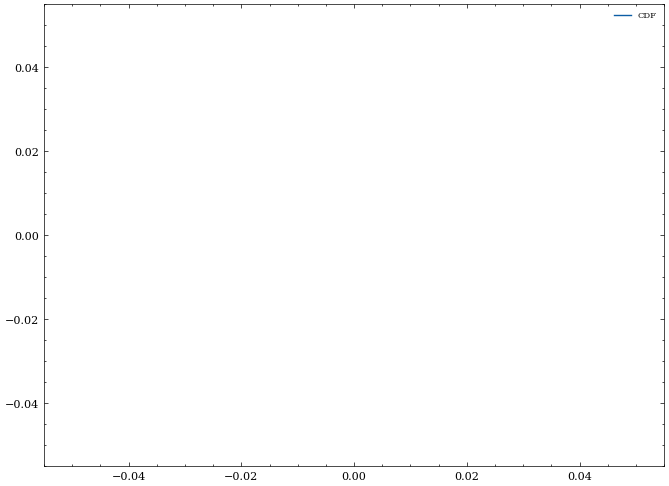

In [48]:
plt.figure(figsize=(8, 6))
count, bins = np.histogram(df_labeled[df_labeled.label == 'Negative'].shannon_entropy, 50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins[1:], cdf, label="CDF")
plt.legend()
plt.show()

In [49]:
df_labeled[df_labeled.label == 'Positive'].shannon_entropy.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: shannon_entropy, dtype: float64

In [50]:
df_labeled[df_labeled.label == 'Negative'].shannon_entropy.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: shannon_entropy, dtype: float64

In [58]:
df_labeled[df_labeled.label == 'ads'].num_nodes.describe()

count    114.000000
mean      45.729378
std      105.154970
min        5.000000
25%       14.703571
50%       18.102679
75%       27.176692
max      778.744186
Name: num_nodes, dtype: float64

/tmp/ipykernel_100071/2252857499.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_negative = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'affiliate'].num_nodes, 50)
/tmp/ipykernel_100071/2252857499.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_positive = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'ads'].num_nodes, 50)


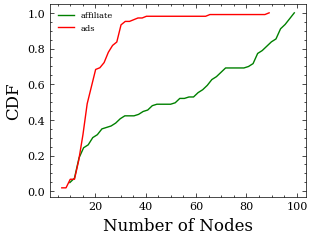

In [59]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'affiliate'].num_nodes, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'ads'].num_nodes, 50)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("Number of Nodes")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_normal_mean_phaseA/number_of_nodes_cdf.pdf", dpi=300, bbox_inches='tight')

In [54]:
cdf_negative[6]

nan

In [55]:
cdf_positive[6]

0.3170731707317073

In [56]:
bins_negative[6]

0.12